# Calibration analysis

In [1]:
import os
import re

import numpy as np
import pandas as pd

from snakemake.utils import Paramspace

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

from itertools import product

## Read dataframe with simulation parameters

In [2]:
params = pd.read_csv('../params.csv')
params['outfile'] = [p + '.txt' for p in Paramspace(params).instance_patterns]

Filter for experiments with no causal GxE effect:

In [3]:
params = (params
    .query('r0 == 0 or n_causal_gxe == 0')
    .query('n_causal_g == 200')
    .query('model == "structlmm" or model == "structlmm2"')
    .reset_index(drop=True))

Simulated were 200 SNPs for one gene, both with and without persistent genetic effect, for different environments.

In [4]:
params

,n_cells,model,likelihood,v0,n_causal_g,n_causal_shared,n_causal_gxe,r0,n_snps,n_genes,n_individuals,cells_per_individual,n_env_gxe,n_env_tested,seed,outfile
0,50,structlmm,gaussian,0.03,200,0,0,0.0,200,1,50,fixed,20,20,19350,n_cells~50/model~structlmm/likelihood~gaussian...
1,50,structlmm,gaussian,0.00,200,0,0,0.0,200,1,50,fixed,20,20,19350,n_cells~50/model~structlmm/likelihood~gaussian...
2,50,structlmm,negbin,0.15,200,0,0,0.0,200,1,50,fixed,20,20,19350,n_cells~50/model~structlmm/likelihood~negbin/v...
3,50,structlmm,negbin,0.00,200,0,0,0.0,200,1,50,fixed,20,20,19350,n_cells~50/model~structlmm/likelihood~negbin/v...
4,50,structlmm2,gaussian,0.03,200,0,0,0.0,200,1,50,fixed,20,20,19350,n_cells~50/model~structlmm2/likelihood~gaussia...
5,50,structlmm2,gaussian,0.00,200,0,0,0.0,200,1,50,fixed,20,20,19350,n_cells~50/model~structlmm2/likelihood~gaussia...
6,50,structlmm2,negbin,0.15,200,0,0,0.0,200,1,50,fixed,20,20,19350,n_cells~50/model~structlmm2/likelihood~negbin/...
7,50,structlmm2,negbin,0.00,200,0,0,0.0,200,1,50,fixed,20,20,19350,n_cells~50/model~structlmm2/likelihood~negbin/...
8,1,structlmm,gaussian,0.03,200,0,0,0.0,200,1,2500,fixed,20,20,19350,n_cells~1/model~structlmm/likelihood~gaussian/...
9,1,structlmm,gaussian,0.00,200,0,0,0.0,200,1,2500,fixed,20,20,19350,n_cells~1/model~structlmm/likelihood~gaussian/...


## Plot quantile distribution

In [5]:
columns = params.drop('outfile', 1).columns
title_cols = columns[params[columns].nunique() > 1].tolist()

In [6]:
title_cols

['n_cells', 'model', 'likelihood', 'v0', 'n_individuals']

In [7]:
def qqplot(x, ax, **plot_kwargs):
    (osm, osr), _ = probplot(x, dist='uniform')
    df = pd.DataFrame({'osm': -np.log10(osm), 'osr': -np.log10(osr)})
    sns.scatterplot(x='osm', y='osr', data=df, ax=ax, edgecolor=None, s=12, **plot_kwargs)
    m = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([0, m], [0, m], c='grey', linestyle=':')
    ax.set(xlabel=r'Expected $-\log_{10} P$', ylabel=r'Observed $-\log_{10} P$')

In [8]:
model_colors = {
    'structlmm': sns.color_palette('colorblind')[2],
    'structlmm2': sns.color_palette('colorblind')[0],
    'structlmm2_fixed': sns.color_palette('colorblind')[9]
}

plt.rcParams.update({'font.size': 8})

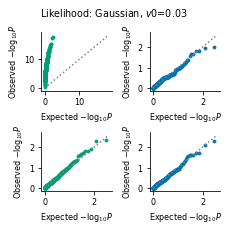

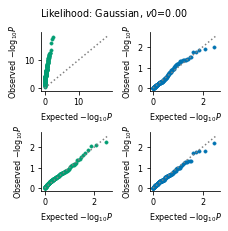

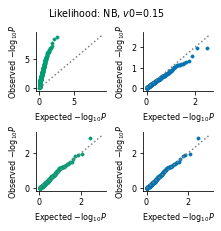

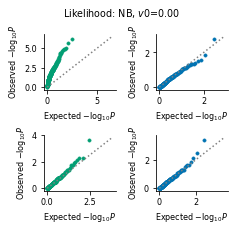

In [9]:
ll_names = {'negbin': 'NB', 'gaussian': 'Gaussian'}
for i, (likelihood, v0) in params[['likelihood', 'v0']].drop_duplicates().T.items():
    sub_df = params.query('likelihood == @likelihood and v0 == @v0')

    fig, axes = plt.subplots(2, 2, figsize=(2*1.6, 2*1.6))
    for i, (n_cells, model) in enumerate(product([50, 1], ['structlmm', 'structlmm2'])):
        filename = sub_df.query('n_cells == @n_cells and model == @model')['outfile'].item()
        fpath = '../results/simulations/' + filename
        pvals = pd.read_csv(fpath, header=None).to_numpy().flatten()
        qqplot(pvals, axes.flatten()[i], color=model_colors[model], rasterized=True)
    fig.suptitle('Likelihood: %s, $v0$=%.2f' % (ll_names[likelihood], v0))
    plt.tight_layout()
    sns.despine()
    
    plt.savefig('plots/calibration_%s_%s.svg' % (likelihood, v0), dpi=300)